# Imports and Loading data


In [168]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import download
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    classification_report,
    f1_score,
    recall_score,
    precision_score,
)
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns

In [169]:
download("stopwords")
download("punkt")

[nltk_data] Downloading package stopwords to /Users/dpapp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dpapp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [170]:
dataFiles = [
    "600_trans.tsv",
    "601_trans.tsv",
    "603_trans_3.tsv",
    "604_trans.tsv",
    "614_trans.tsv",
]

data = None

for dataFile in dataFiles:
    print("Processing file: " + dataFile)

    data = pd.concat(
        [data, pd.read_csv("input/" + dataFile, sep="\t")], ignore_index=True
    )

Processing file: 600_trans.tsv
Processing file: 601_trans.tsv
Processing file: 603_trans_3.tsv
Processing file: 604_trans.tsv
Processing file: 614_trans.tsv


In [171]:
data.head(10)

,name,features,transcript,cluster,number,hours,prefix
0,Course Introduction,"In the video, the instructor of the course ENM...","Well, greetings and welcome to the first lectu...",24,1.0,1.0,CEFA
1,Business Ethics,"In this lecture on business ethics, the instru...","Greetings. Hello again. In this lecture, we'll...",25,2.0,1.0,CEFA
2,Introduction to Managerial Finance and Accounting,"In this video, the instructor introduces stude...","Well, hello again and welcome back. In this le...",26,3.0,1.0,CEFA
3,Introduction to Accounting,"In this video, students will learn about the i...","Greetings. In this lecture, we're going to cov...",26,3.1,1.0,CEFA
4,Financial Statements - Income statements and r...,"In this video, the instructor introduces the i...",Greetings. In this lecture. We're going to beg...,26,3.2,1.0,CEFA
5,Financial Statements - Balance sheet,In the video transcript for the course ENMA 60...,Greetings In this lecture. We're going to cont...,26,3.3,1.0,CEFA
6,Financial Statements - Cash Flow,"In this video transcript, the instructor empha...","Hello again. In this lecture, we're going to c...",26,3.4,1.0,CEFA
7,Analyzing Financial Statements and Financial P...,The video introduces the concept of ratio anal...,Greetings Over the last several lectures we've...,26,3.5,1.0,CEFA
8,Analyzing Cash Flow,The key takeaway from this video is that analy...,Greetings. As we discussed in an earlier lectu...,27,4.0,1.0,CEFA
9,Cash and Profit Planning,"In this video, the instructor focuses on the i...","Hello again. In today's lecture, we're going t...",27,4.1,1.0,CEFA


# Preprocessing


In [172]:
sw = set(stopwords.words("english"))

In [173]:
sw.add("module")
sw.add("course")
sw.add("problem")
sw.add("use")
sw.add("model")
sw.add("solution")
sw.add("solve")
sw.add("analyze")
sw.add("example")
sw.add("application")
sw.add("computer")
sw.add("computers")
sw.add("zero")
sw.add("one")
sw.add("two")
sw.add("three")
sw.add("four")
sw.add("five")
sw.add("six")
sw.add("seven")
sw.add("eight")
sw.add("nine")
sw.add("x")
sw.add("c")
sw.add("k")
sw.add("l")
sw.add("b")
sw.add("go")
sw.add("constraint")
sw.add("get")
sw.add("ok")
sw.add("uh")
sw.add("shift")
sw.add("see")
sw.add("give")
sw.add("take")
sw.add("right")
sw.add("know")
sw.add("want")
sw.add("may")
sw.add("way")
sw.add("say")
sw.add("let")
sw.add("thing")
sw.add("look")
sw.add("need")
sw.add("would")
sw.add("try")
sw.add("back")
sw.add("also")
sw.add("must")
sw.add("okay")
sw.add("talk")
sw.add("well")
sw.add("like")
sw.add("basically")
sw.add("maybe")

In [174]:
data["combined"] = (
    "Title: "
    + data.name.str.strip()
    + "; Description: "
    + data.features.str.strip()
    + "; Transcript: "
    + data.transcript.str.strip()
)

In [175]:
def remove_stopwords(text):
    filtered_sentence = [w for w in text if not w in sw]
    return " ".join(filtered_sentence)

In [176]:
import string

# lowercase all words in the combined column of the data dataframe
data["combined"] = data["combined"].apply(lambda x: x.lower())

# remove newline characters from the combined column of the data dataframe
data["combined"] = data["combined"].apply(lambda x: x.replace("\n", " "))

# remove punctuation from the combined column of the data dataframe
data["combined"] = data["combined"].apply(
    lambda x: x.translate(str.maketrans("", "", string.punctuation))
)

# remove numbers from the combined column of the data dataframe
data["combined"] = data["combined"].apply(
    lambda x: x.translate(str.maketrans("", "", string.digits))
)

# tokenize the combined column of the data dataframe
data["combined"] = data["combined"].apply(lambda x: word_tokenize(x))

# remove stopwords from the combined column of the data dataframe
data["combined"] = data["combined"].apply(
    lambda x: [word for word in x if word not in sw]
)

In [177]:
w2v = data.copy()

# Embedding Models


## Word2Vec


In [178]:
word2vec = Word2Vec(
    sentences=w2v["combined"].values, min_count=3, sg=1, window=15, workers=8
)

In [179]:
for index, word in enumerate(word2vec.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(word2vec.wv.index_to_key)} is {word}")

word #0/6856 is going
word #1/6856 is project
word #2/6856 is time
word #3/6856 is thats
word #4/6856 is people
word #5/6856 is point
word #6/6856 is value
word #7/6856 is cost
word #8/6856 is lets
word #9/6856 is cash


In [180]:
word2vec.wv.most_similar("finance")

[('managerial', 0.8100178837776184),
 ('accounting', 0.7837196588516235),
 ('pertains', 0.7251716256141663),
 ('accountants', 0.7085089683532715),
 ('fundraising', 0.7070609331130981),
 ('enterprise', 0.7032265067100525),
 ('accrual', 0.6965333819389343),
 ('proprietorships', 0.6919685006141663),
 ('largely', 0.6889185309410095),
 ('externally', 0.6878337264060974)]

In [181]:
emb_df = pd.DataFrame(
    [word2vec.wv.get_vector(str(n)) for n in word2vec.wv.key_to_index],
    index=word2vec.wv.key_to_index,
)
print(emb_df.shape)
emb_df.head()

(6856, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
going,0.049396,0.309555,-0.073906,0.071398,0.170983,-0.323466,-0.088365,-0.027497,-0.202928,-0.212980,...,0.274481,-0.198753,-0.134321,0.060240,0.128037,-0.003729,0.119612,-0.011067,-0.046338,-0.135755
project,-0.246387,0.301092,-0.344700,-0.205046,-0.069534,0.007865,-0.197957,0.399693,-0.107482,-0.598998,...,0.203143,-0.004445,-0.239986,-0.216780,-0.083535,0.043671,0.226008,-0.519043,-0.462739,-0.290993
time,-0.216813,0.136840,-0.437290,0.087878,0.385946,0.119611,-0.723588,-0.194334,-0.105156,-0.026336,...,0.299264,-0.101858,-0.197334,0.362192,-0.125552,0.071563,-0.021720,-0.505512,-0.411126,-0.087434
thats,-0.074614,0.353891,-0.065645,0.112200,0.053631,-0.181504,-0.220926,-0.118263,0.106580,-0.075976,...,0.186103,0.214502,-0.183713,0.318543,-0.010216,-0.278829,0.265327,-0.005837,0.072843,-0.064131
people,-0.135399,0.276000,-0.082701,-0.267626,0.221417,-0.283694,-0.588740,-0.152984,-0.431349,-0.103629,...,0.359797,-0.011903,0.026757,-0.262266,-0.247628,-0.211880,0.260502,-0.265272,0.539447,-0.280641


In [182]:
emb_df.to_csv("output/w2v_embeddings.tsv", index=True, sep="\t", header=False)

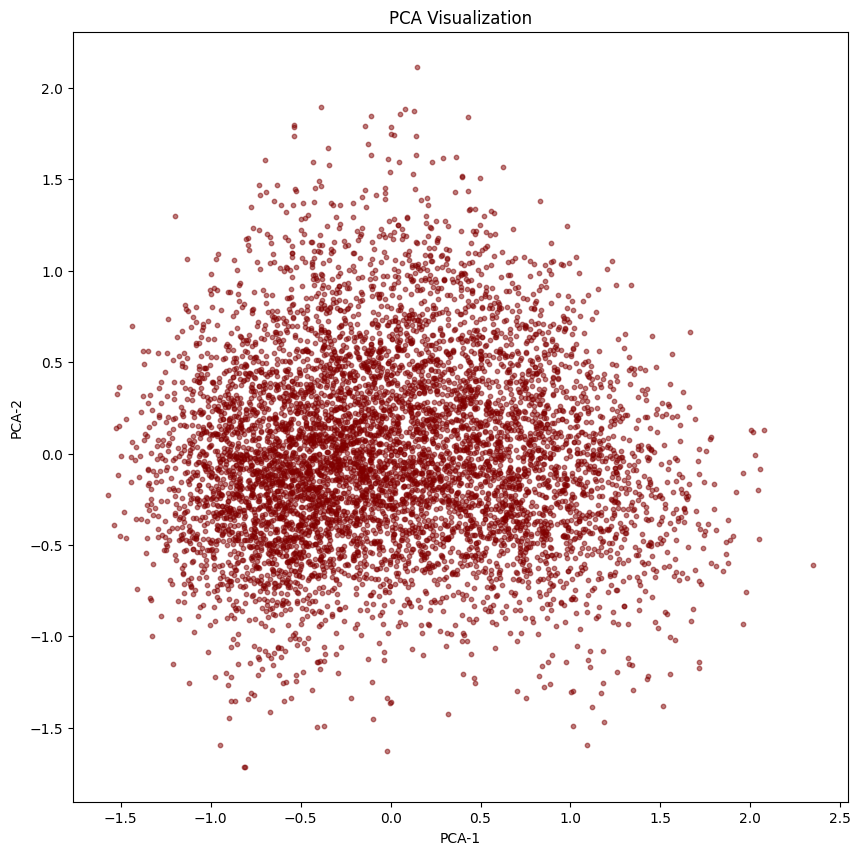

In [183]:
pca = PCA(n_components=2, random_state=7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = pd.DataFrame(pca_mdl, columns=["x", "y"], index=emb_df.index)

fig = plt.figure(figsize=(10, 10))

plt.scatter(x=emb_df_PCA["x"], y=emb_df_PCA["y"], s=10, color="maroon", alpha=0.5)

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title("PCA Visualization")
plt.plot()
plt.show()

In [184]:
tsne = TSNE(
    n_components=2, random_state=42, perplexity=16, learning_rate=10, n_iter=3000
)

tsne_results = tsne.fit_transform(emb_df)

tsne_df = pd.DataFrame(tsne_results, columns=["x", "y"])

tsne_df["label"] = emb_df.index

tsne_df.head()

,x,y,label
0,18.003408,-16.688692,going
1,-1.300314,2.358286,project
2,34.152752,5.286467,time
3,28.801519,-26.854584,thats
4,-38.862701,-9.973072,people


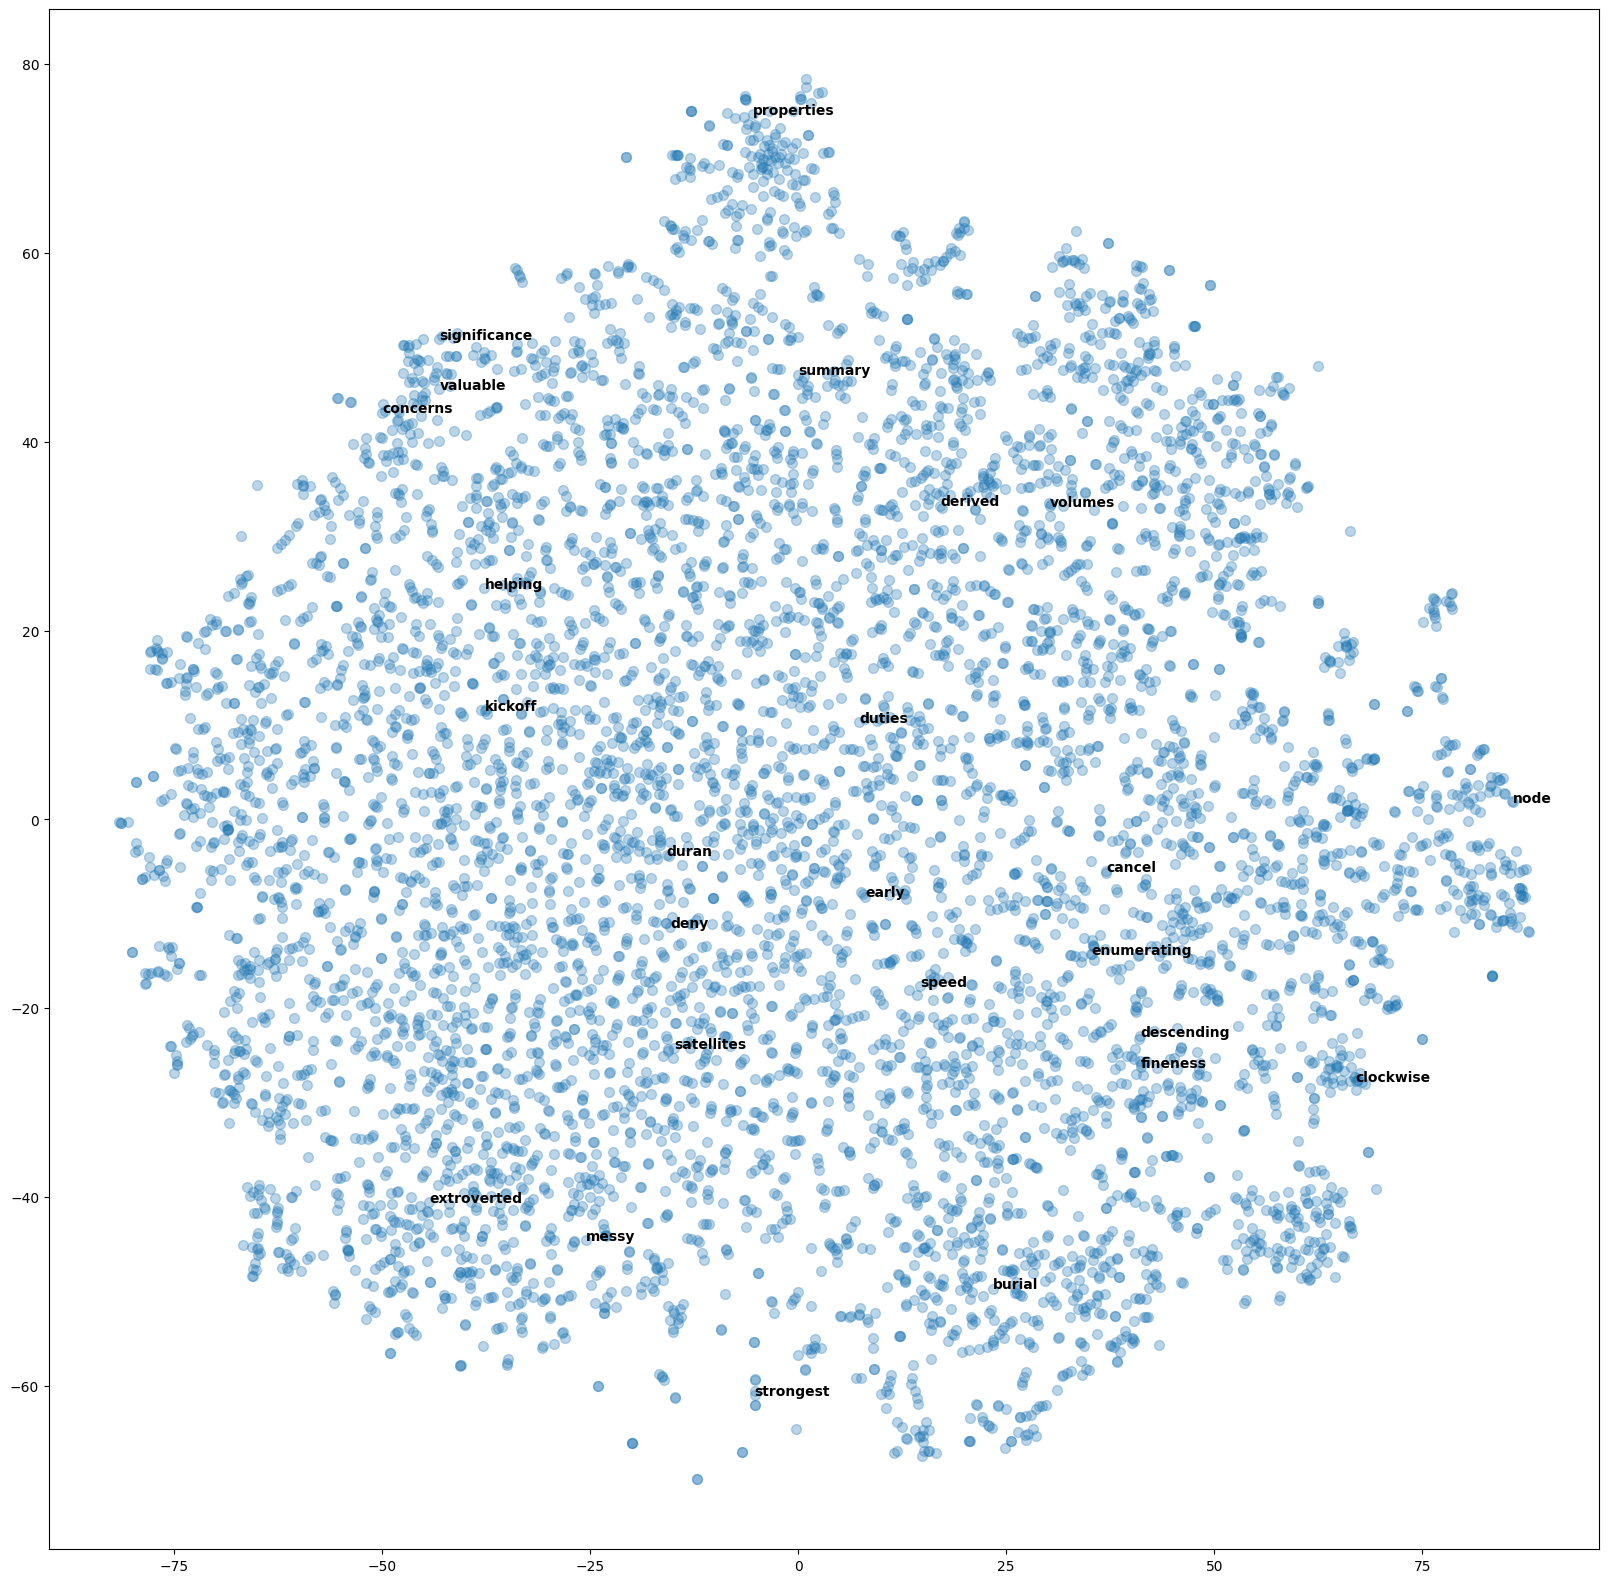

In [185]:
# plot x and y using matplotlib with label as a text on a radom 25 sample of the dataset

plt.figure(figsize=(20, 20))
plt.scatter(tsne_df.x, tsne_df.y, s=50, alpha=0.3)

annot_array = np.random.choice(tsne_df.index, 25, replace=False)

for i in annot_array:
    plt.text(
        s=tsne_df.label[i],
        x=tsne_df.x[i],
        y=tsne_df.y[i],
        fontdict={"fontsize": 10, "fontweight": "bold"},
    )

plt.show()

## Doc2Vec


In [186]:
# set up dataset for doc 2 vector embedding

d2v = data.copy()

In [187]:
doc2vec = Doc2Vec(vector_size=100, min_count=2, epochs=100)

In [188]:
# tokenize each word in the combined column of the d2v dataframe

d2v["converted"] = d2v.combined.map(lambda elm: " ".join(elm))

d2v["tagged"] = d2v.apply(
    lambda r: TaggedDocument(words=word_tokenize(r["converted"]), tags=[r.index]),
    axis=1,
)

d2v.head()

,name,features,transcript,cluster,number,hours,prefix,combined,converted,tagged
0,Course Introduction,"In the video, the instructor of the course ENM...","Well, greetings and welcome to the first lectu...",24,1.0,1.0,CEFA,"[title, introduction, description, video, inst...",title introduction description video instructo...,"([title, introduction, description, video, ins..."
1,Business Ethics,"In this lecture on business ethics, the instru...","Greetings. Hello again. In this lecture, we'll...",25,2.0,1.0,CEFA,"[title, business, ethics, description, lecture...",title business ethics description lecture busi...,"([title, business, ethics, description, lectur..."
2,Introduction to Managerial Finance and Accounting,"In this video, the instructor introduces stude...","Well, hello again and welcome back. In this le...",26,3.0,1.0,CEFA,"[title, introduction, managerial, finance, acc...",title introduction managerial finance accounti...,"([title, introduction, managerial, finance, ac..."
3,Introduction to Accounting,"In this video, students will learn about the i...","Greetings. In this lecture, we're going to cov...",26,3.1,1.0,CEFA,"[title, introduction, accounting, description,...",title introduction accounting description vide...,"([title, introduction, accounting, description..."
4,Financial Statements - Income statements and r...,"In this video, the instructor introduces the i...",Greetings. In this lecture. We're going to beg...,26,3.2,1.0,CEFA,"[title, financial, statements, income, stateme...",title financial statements income statements r...,"([title, financial, statements, income, statem..."


## BERT


In [240]:
from sklearn.linear_model import LogisticRegression
import transformers
import torch

corpus = data.copy()
model_name = "bert-base-uncased"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModel.from_pretrained(model_name)


def embed(text):
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)
    with torch.no_grad():
        output = model(input_ids)
    embeddings = output.last_hidden_state.mean(dim=1).squeeze()
    return embeddings.numpy()


embeddings = [embed(doc) for doc in corpus.name]

X = pd.DataFrame(embeddings)
y = data.cluster

clf = LogisticRegression().fit(X, y)

new_doc = [
    "Corporate Finance",
    "Project Management for Business Professionals",
    "Marketing Management",
    "Network Security",
    "Data Science and Machine Learning",
    "Data Visualization",
    "Cloud Computational Architecture",
    "Linear Algebra",
    "Calculus",
    "Statistics",
    "Data Mining",
    "Computer Architecture",
    "Problem Solving and Programming",
    "Data Structures and Algorithms",
    "Operating Systems",
    "Computer Networks",
    "Database Management Systems",
]
new_embeddings = [embed(doc) for doc in new_doc]
X_new = pd.DataFrame(new_embeddings)

predicted = clf.predict(X_new)
proba = clf.predict_proba(X_new)
accuracy = clf.score(X, y)
f1 = f1_score(y, clf.predict(X), average="weighted", zero_division=0)
recall = recall_score(y, clf.predict(X), average="weighted", zero_division=0)
precision = precision_score(y, clf.predict(X), average="weighted", zero_division=0)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/dpapp/Projects/emse-mms/emse-mms/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to conver

In [241]:
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1: {f1:.2%}")

Accuracy: 99.36%
Precision: 99.04%
Recall: 99.36%
F1: 99.15%


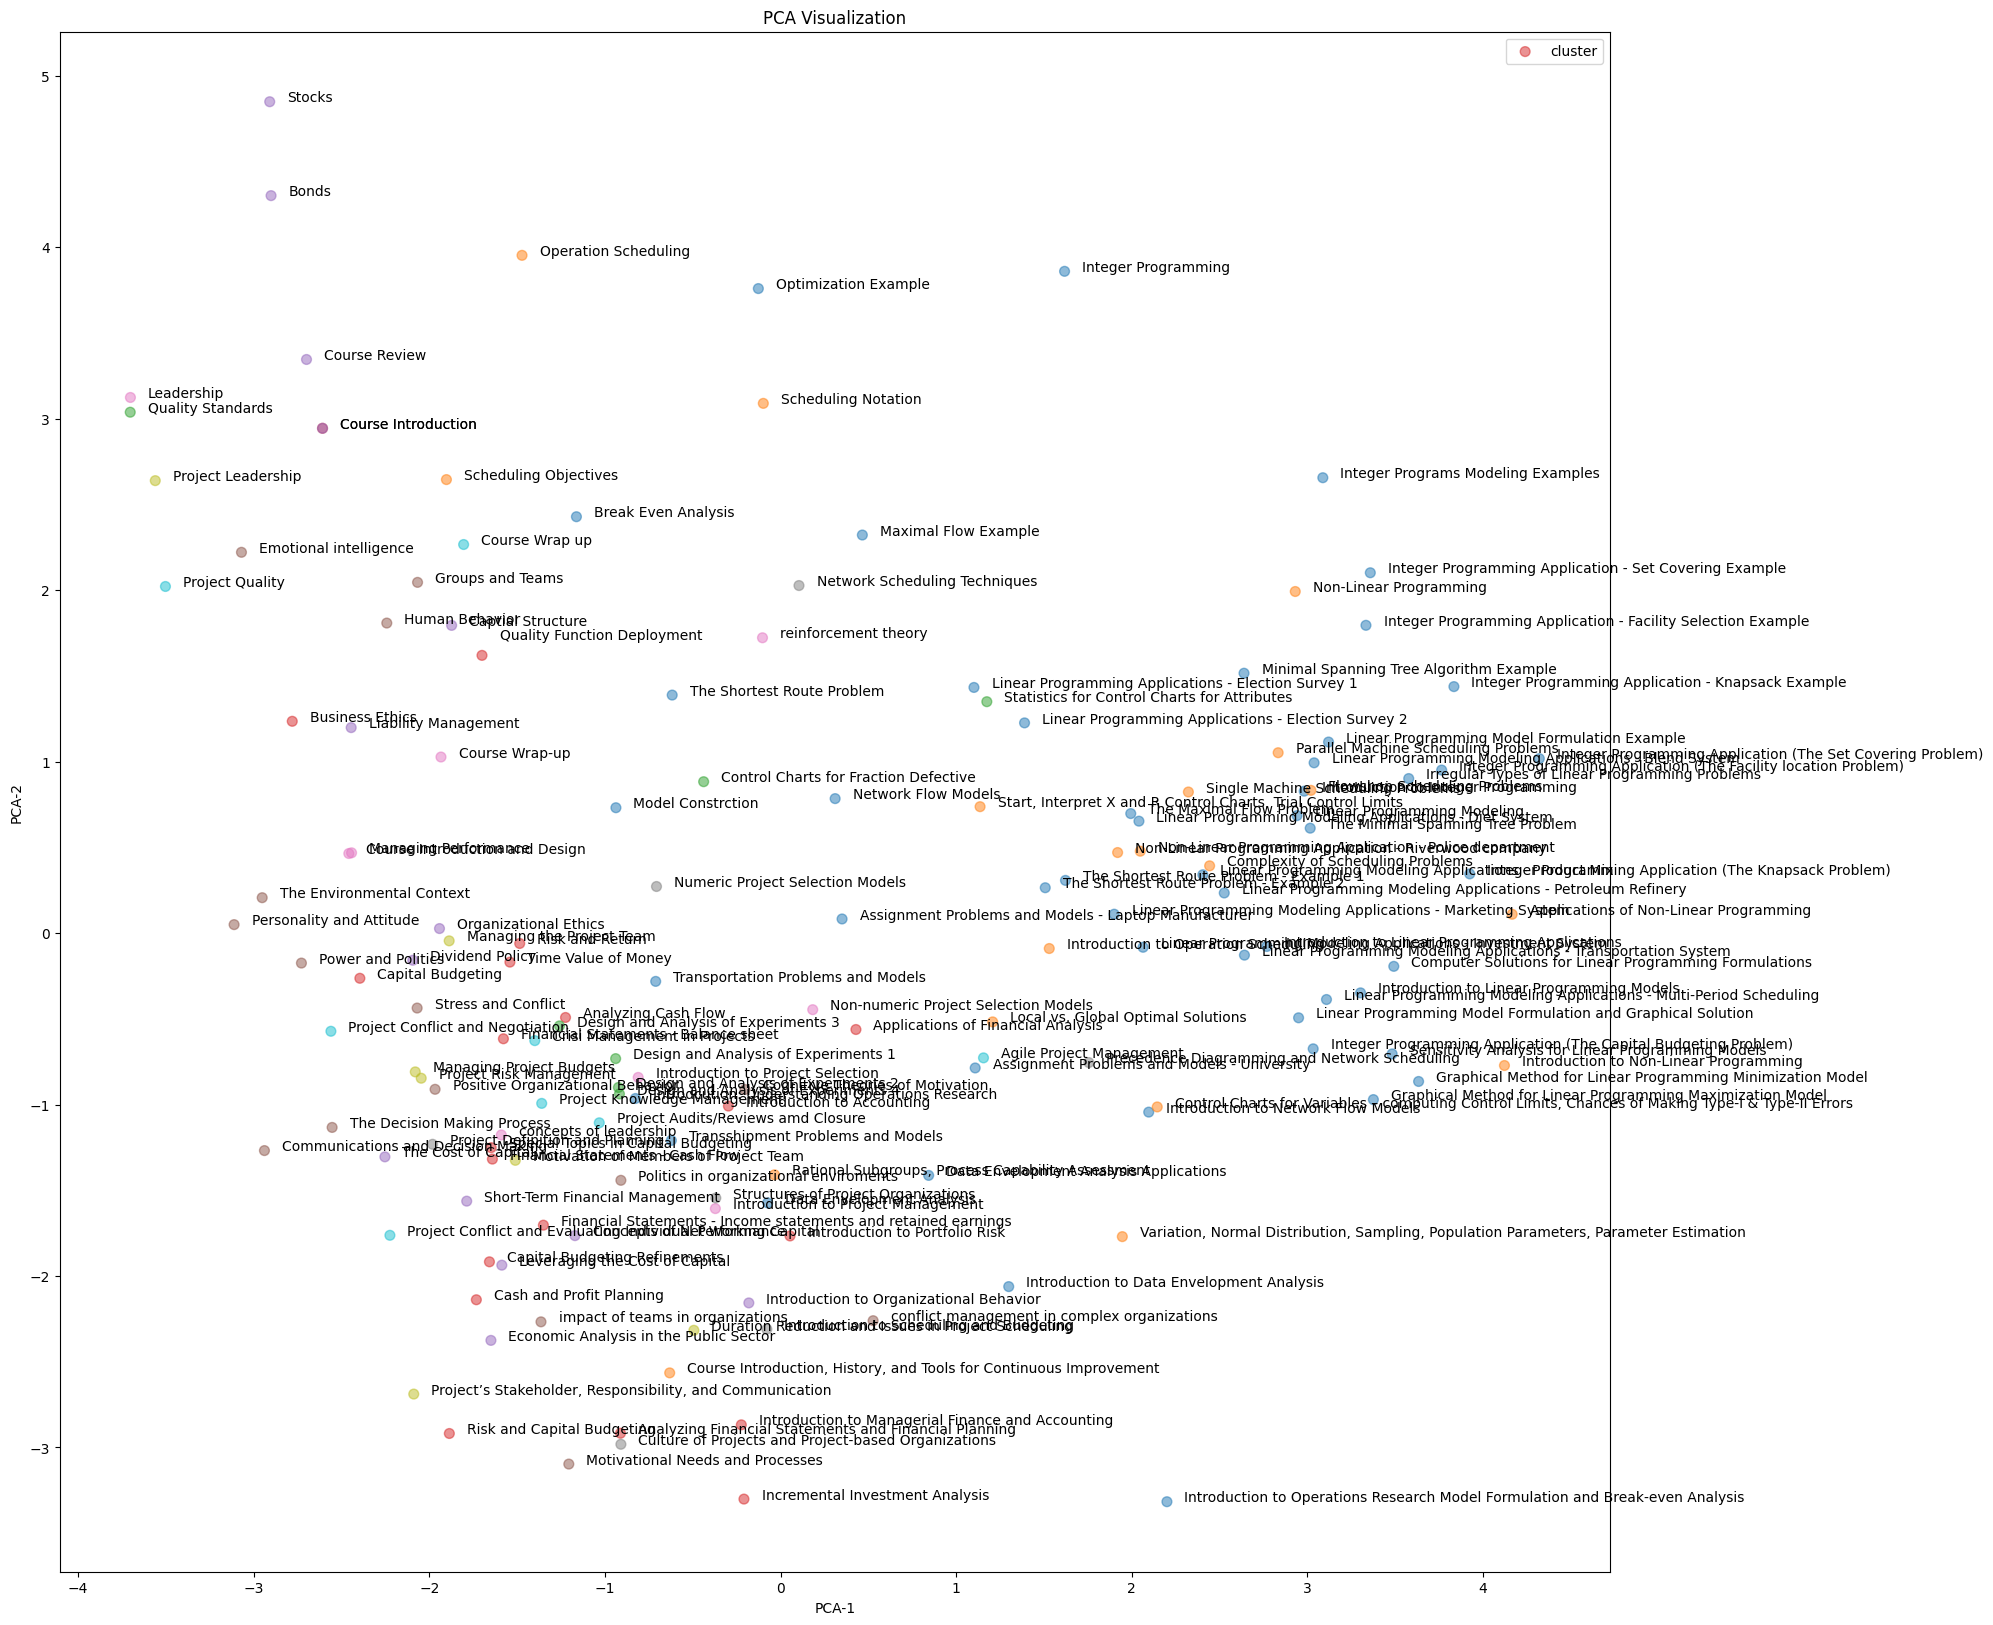

In [242]:
X.index = data.name.values

pca = PCA(n_components=2, random_state=7)
pca_mdl = pca.fit_transform(X)

bert_df_PCA = pd.DataFrame(pca_mdl, columns=["x", "y"], index=X.index)

# use the data dataframe to add the cluster column to the bert_df_PCA dataframe based on the name column
bert_df_PCA["cluster"] = data.cluster.values

fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(
    data=bert_df_PCA,
    x="x",
    y="y",
    s=50,
    cmap="tab10",
    alpha=0.5,
    c="cluster",
    label="cluster",
)

for i, txt in enumerate(bert_df_PCA.index):
    ax.annotate(txt, (bert_df_PCA["x"][i] + 0.1, bert_df_PCA["y"][i]))

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title("PCA Visualization")
plt.legend()
plt.plot()
plt.show()

In [243]:
le = LabelEncoder()

X_new.index = new_doc

pca = PCA(n_components=2, random_state=7)
pca_mdl_new = pca.fit_transform(X_new)

bert_df_PCA_new = pd.DataFrame(pca_mdl_new, columns=["x", "y"], index=X_new.index)

le.fit(new_doc)

# use the data dataframe to add the cluster column to the bert_df_PCA dataframe based on the name column
bert_df_PCA_new["cluster"] = le.transform(new_doc)

bert_df_PCA["label"] = bert_df_PCA.index

bert_df_PCA_new["label"] = bert_df_PCA_new.index

bert_df_PCA_new.reset_index(drop=True, inplace=True)

bert_df_PCA.reset_index(drop=True, inplace=True)

In [244]:
bert_df_PCA_new.head()

,x,y,cluster,label
0,1.884116,2.455001,4,Corporate Finance
1,-1.279360,4.864042,15,Project Management for Business Professionals
2,1.554327,3.195438,11,Marketing Management
3,2.092883,-0.380956,12,Network Security
4,-3.979825,-1.384029,6,Data Science and Machine Learning


In [245]:
bert_df_PCA.head()

,x,y,cluster,label
0,-2.608190,2.943478,24,Course Introduction
1,-2.780559,1.234843,25,Business Ethics
2,-0.223219,-2.868006,26,Introduction to Managerial Finance and Accounting
3,-0.296708,-1.009123,26,Introduction to Accounting
4,-1.350444,-1.703672,26,Financial Statements - Income statements and r...


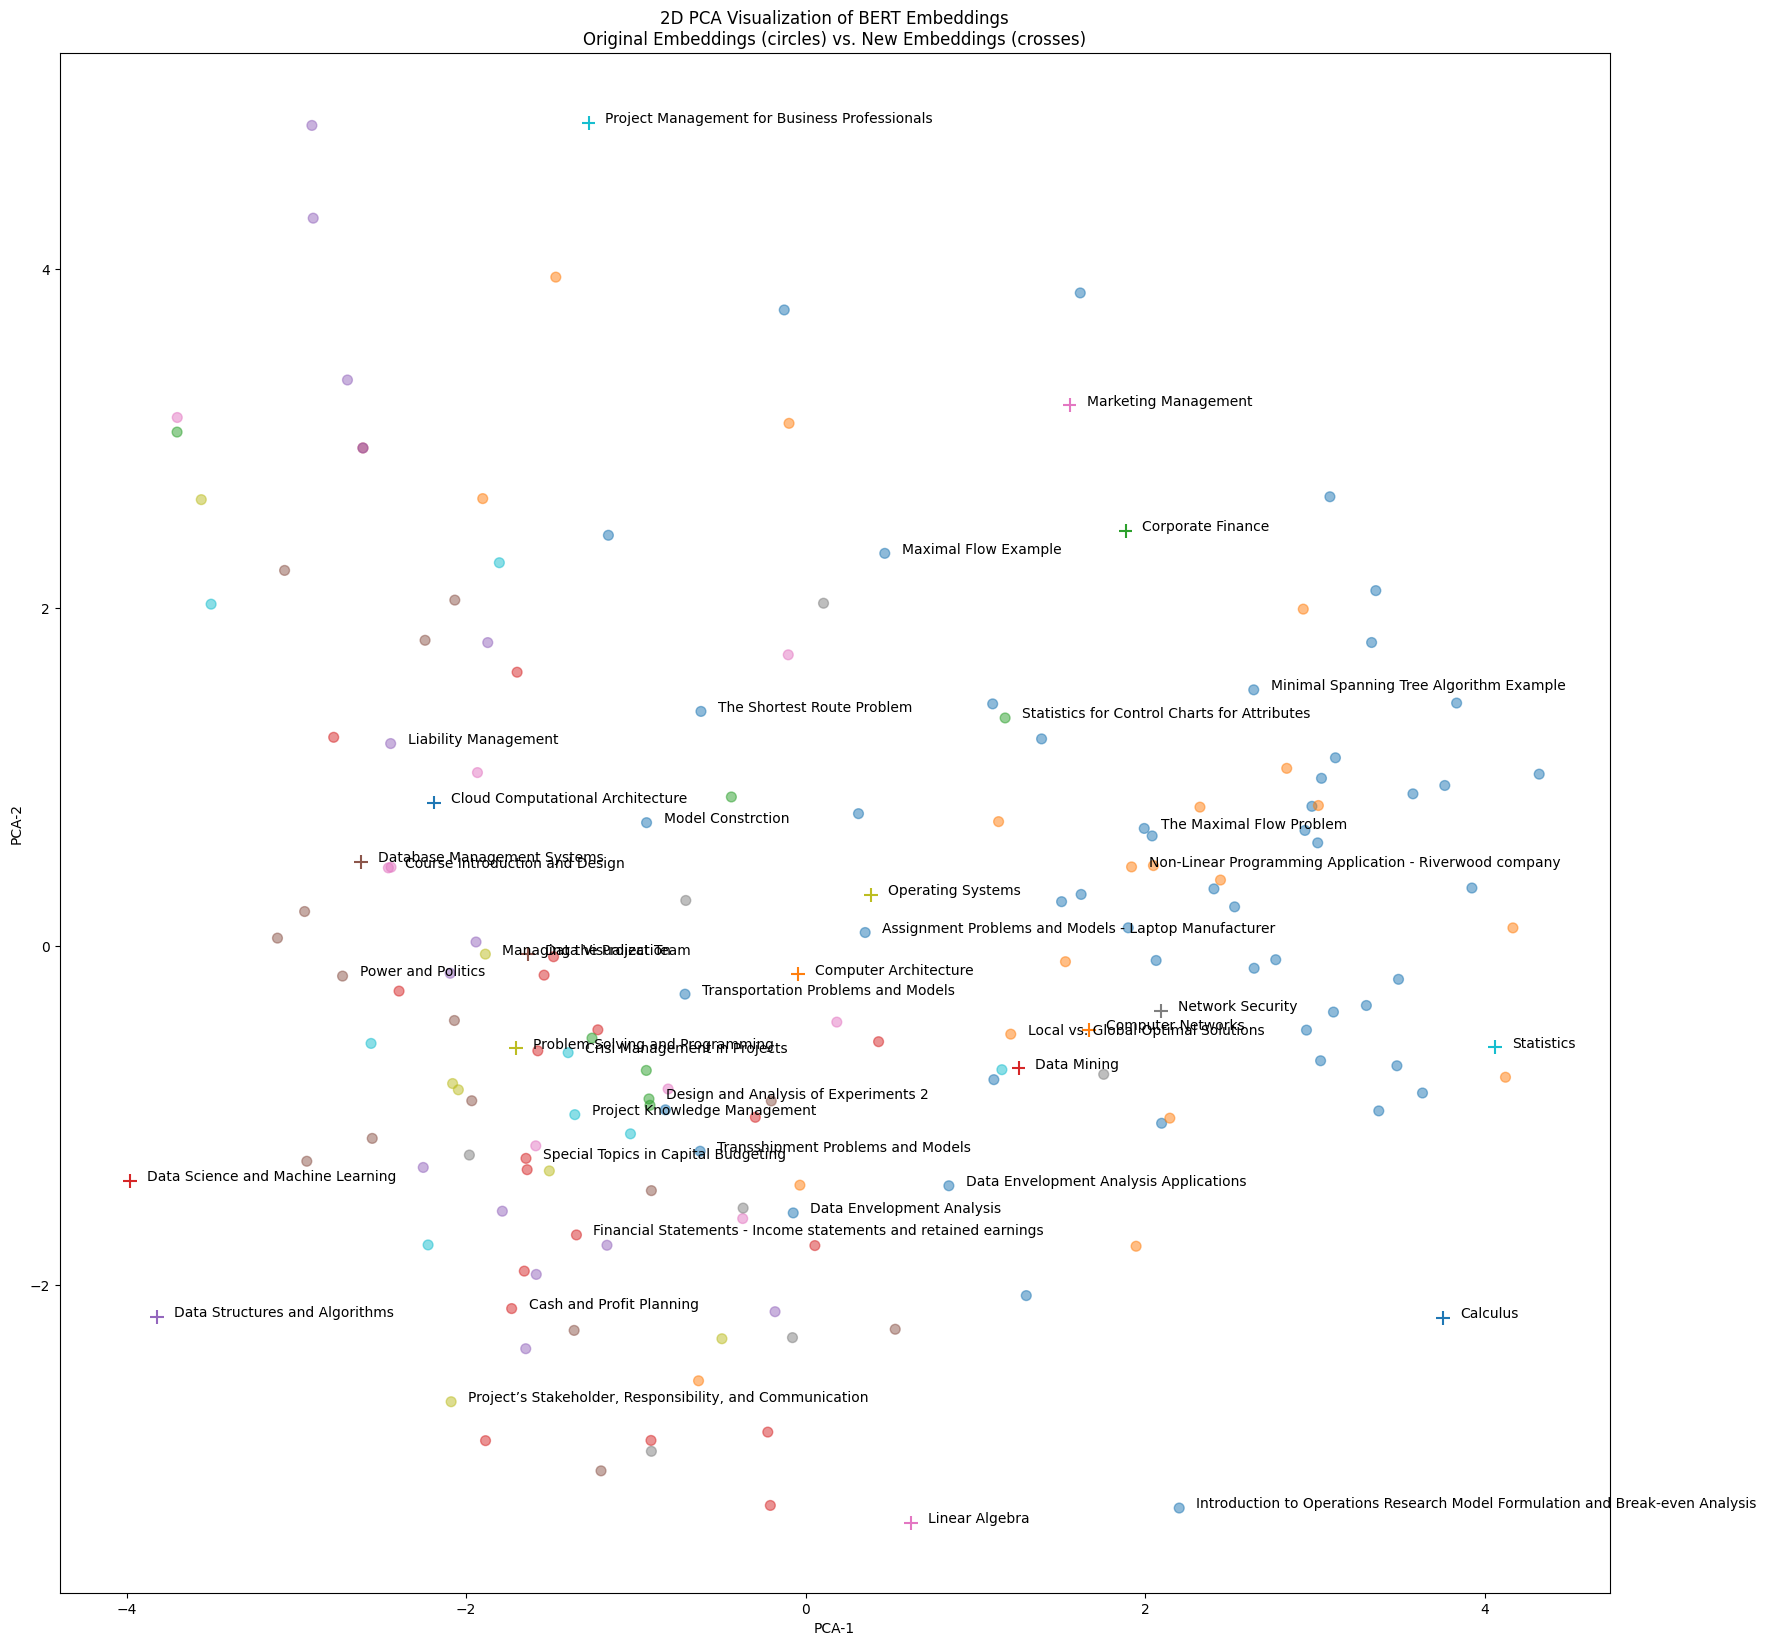

In [247]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(
    data=bert_df_PCA,
    x="x",
    y="y",
    s=50,
    cmap="tab10",
    alpha=0.5,
    c="cluster",
)

ax.scatter(
    data=bert_df_PCA_new, x="x", y="y", s=100, cmap="tab10", c="cluster", marker="+"
)

annot_array_bert = np.random.choice(bert_df_PCA.index, 25, replace=False)

for i, txt in enumerate(bert_df_PCA_new.index):
    ax.annotate(
        bert_df_PCA_new["label"][i],
        (bert_df_PCA_new["x"][i] + 0.1, bert_df_PCA_new["y"][i]),
    )

for r in annot_array_bert:
    ax.annotate(
        bert_df_PCA["label"][r], (bert_df_PCA["x"][r] + 0.1, bert_df_PCA["y"][r])
    )

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title(
    "2D PCA Visualization of BERT Embeddings\nOriginal Embeddings (circles) vs. New Embeddings (crosses)"
)
plt.show()

### BERT using Combined Text Content


In [308]:
train_data = data.copy()
model_name = "bert-base-uncased"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModel.from_pretrained(model_name)


def embed(text):
    input_ids = torch.tensor(tokenizer.encode(text, truncation=True)).unsqueeze(0)
    with torch.no_grad():
        output = model(input_ids)
    embeddings = output.last_hidden_state.mean(dim=1).squeeze()
    return embeddings.numpy()


vocab = []
vocab_cluster = []
vocab_label = []

for row in train_data.iterrows():
    sentence = ""
    for element in row[1]["combined"]:
        sentence += str(element) + " "

    vocab.append(sentence)
    vocab_cluster.append(row[1]["cluster"])
    vocab_label.append(row[1]["name"])

vocab = pd.DataFrame({"vocab": vocab, "cluster": vocab_cluster, "label": vocab_label})

embeddings = [embed(doc) for doc in vocab.vocab]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [330]:
new_doc = [
    "Corporate Finance: This course delves into the financial decisions and strategies that corporations make to optimize their capital structure, investment projects, and risk management. Students learn about valuation methods, capital budgeting, risk analysis, and financial markets' impact on a company's financial health.",
    "Project Management for Business Professionals: In this course, students gain a comprehensive understanding of project management techniques, including planning, execution, monitoring, and closing of projects within a business context. The course covers topics such as project scope, time management, resource allocation, communication, and stakeholder engagement to ensure successful project delivery.",
    "Marketing Management: Marketing Management explores the principles of creating, promoting, and delivering value to customers, encompassing market analysis, consumer behavior, branding, and market segmentation. Students learn to design effective marketing strategies, utilize various marketing channels, and adapt to the ever-changing landscape of consumer preferences.",
    "Network Security: This course focuses on safeguarding digital communication networks from cyber threats by covering encryption, authentication, intrusion detection, and security protocols. Students gain insights into the techniques used by hackers and learn countermeasures to secure networks and data from unauthorized access and cyberattacks.",
    "Data Science and Machine Learning: Data Science and Machine Learning explore the process of deriving insights and making predictions from large datasets using algorithms and statistical models. Students delve into data preprocessing, feature engineering, model selection, and evaluation, enabling them to build machine learning models for various applications.",
    "Data Visualization: This course emphasizes the effective representation of data through graphs, charts, and interactive visuals to convey insights and patterns in a compelling and accessible manner. Students learn about visualization principles, tools, and techniques to communicate complex data stories to diverse audiences.",
    "Cloud Computational Architecture: Cloud Computational Architecture covers the design and management of scalable and reliable cloud-based systems, including virtualization, distributed computing, and cloud service models. Students explore cloud architecture patterns, deployment strategies, and technologies that enable businesses to leverage the flexibility and efficiency of cloud computing.",
    "Linear Algebra: Linear Algebra deals with vector spaces, linear transformations, and matrices, forming the foundation for various fields such as computer graphics, physics, and machine learning. Students learn about solving systems of linear equations, eigenvalues, eigenvectors, and applications in solving real-world problems.",
    "Calculus: Calculus introduces fundamental concepts of limits, derivatives, and integrals, providing tools to analyze change and motion in mathematics, science, and engineering. Students explore differential and integral calculus, uncovering relationships between functions and their rates of change or accumulation.",
    "Statistics: Statistics involves collecting, analyzing, and interpreting data to make informed decisions and predictions, covering topics like probability, hypothesis testing, and regression analysis. Students acquire skills in designing experiments, summarizing data, and drawing meaningful conclusions from a wide range of contexts.",
    "Data Mining: Data Mining focuses on discovering patterns, relationships, and insights from large datasets through techniques like clustering, association rule mining, and anomaly detection. Students learn to identify hidden patterns in diverse data sources, enabling informed decision-making and predictive modeling.",
    "Computer Architecture: Computer Architecture explores the design and organization of computer systems, including the central processing unit, memory hierarchy, and instruction set architecture. Students study the trade-offs between performance, energy efficiency, and cost in designing hardware components that form the basis of modern computing.",
    "Problem Solving and Programming: This course teaches the fundamentals of algorithmic problem-solving and programming, enabling students to design, implement, and debug software solutions. Students learn programming concepts, control structures, and data types to develop the skills necessary for software development and computational thinking.",
    "Data Structures and Algorithms: Data Structures and Algorithms focus on organizing and processing data efficiently, covering topics like arrays, linked lists, sorting algorithms, and search techniques. Students gain insights into selecting appropriate data structures and designing algorithms to solve computational problems in various domains.",
    "Operating Systems: Operating Systems delve into the management of computer hardware and software resources, including process management, memory allocation, and file systems. Students explore the role of operating systems in providing a stable and secure environment for software applications to run and communicate with hardware.",
    "Computer Networks: Computer Networks examine the principles of data communication and network architecture, including protocols, routing, network layers, and internet technologies. Students learn about designing, implementing, and maintaining network infrastructures that enable seamless data exchange across diverse devices and locations.",
    "Database Management Systems: Database Management Systems cover the design, implementation, and management of databases to store, retrieve, and manipulate structured data efficiently. Students study database models, normalization, SQL queries, and transaction management to ensure data integrity and support information-centric applications.",
]

In [345]:
X = pd.DataFrame(embeddings)
y = vocab.cluster

clf = LogisticRegression().fit(X, y)

new_doc_names = [
    "Corporate Finance",
    "Project Management for Business Professionals",
    "Marketing Management",
    "Network Security",
    "Data Science and Machine Learning",
    "Data Visualization",
    "Cloud Computational Architecture",
    "Linear Algebra",
    "Calculus",
    "Statistics",
    "Data Mining",
    "Computer Architecture",
    "Problem Solving and Programming",
    "Data Structures and Algorithms",
    "Operating Systems",
    "Computer Networks",
    "Database Management Systems",
]

new_embeddings = [embed(doc) for doc in new_doc]
X_new = pd.DataFrame(new_embeddings)

predicted = clf.predict(X_new)
proba = clf.predict_proba(X_new)
accuracy = clf.score(X, y)
f1 = f1_score(y, clf.predict(X), average="weighted", zero_division=0)
recall = recall_score(y, clf.predict(X), average="weighted", zero_division=0)
precision = precision_score(y, clf.predict(X), average="weighted", zero_division=0)

/Users/dpapp/Projects/emse-mms/emse-mms/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [346]:
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1: {f1:.2%}")

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1: 100.00%


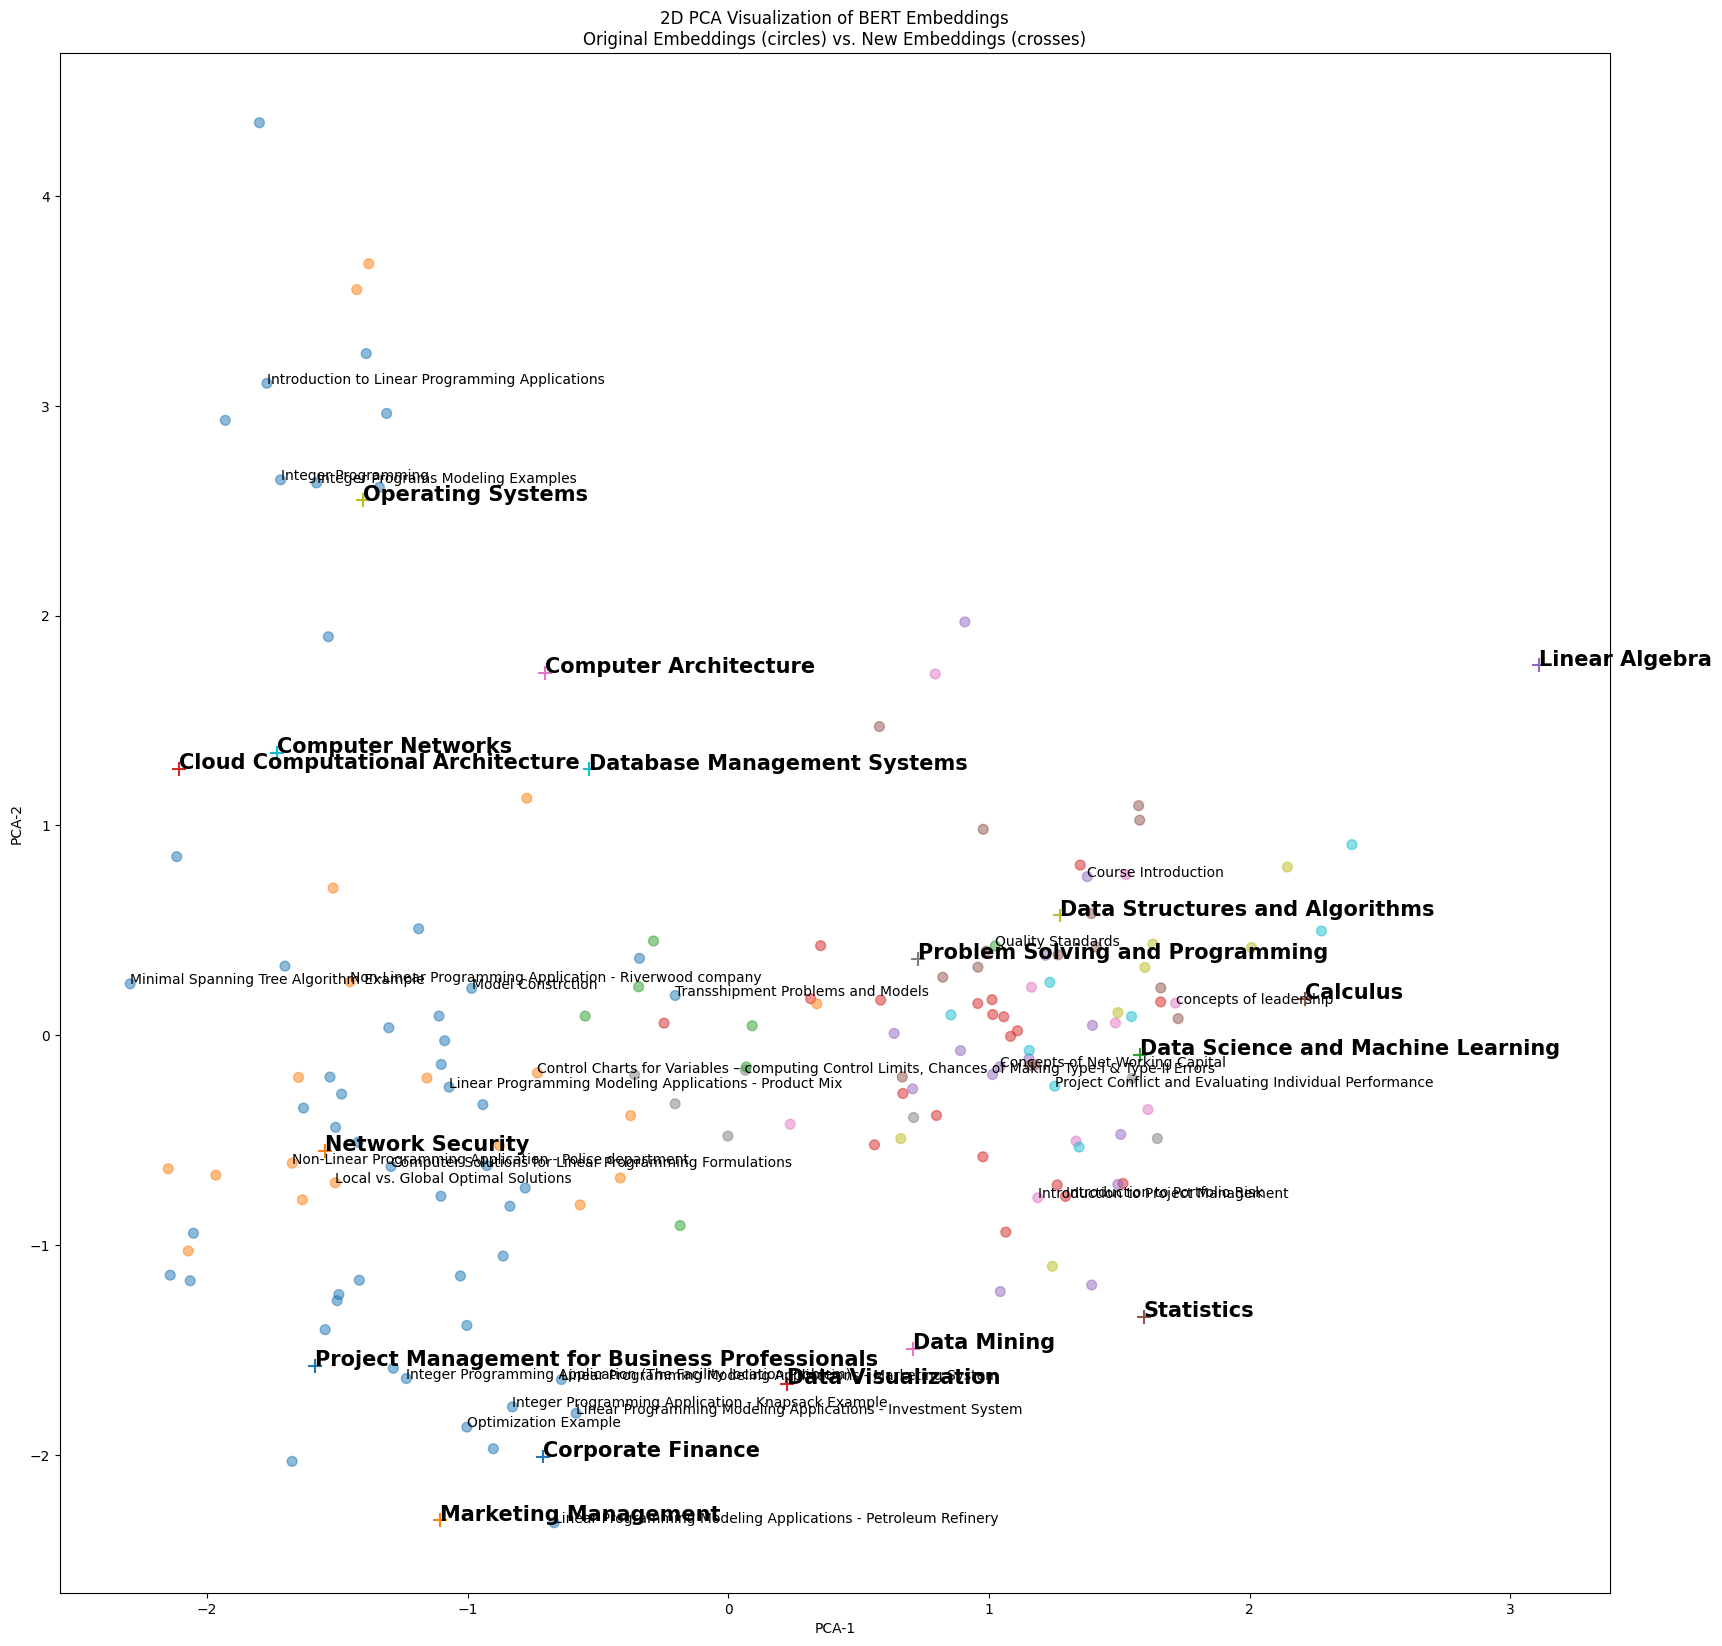

In [347]:
bert_pca = PCA(n_components=2, random_state=123)
bert_pca_x = pca.fit_transform(X)

bert_pca_df = pd.DataFrame(
    {"x": bert_pca_x[:, 0], "y": bert_pca_x[:, 1], "label": vocab.label, "cluster": y}
)

bert_pca_x_test = pca.fit_transform(X_new)

bert_pca_x_test_df = pd.DataFrame(
    {
        "x": bert_pca_x_test[:, 0],
        "y": bert_pca_x_test[:, 1],
        "label": new_doc,
        "cluster": range(len(new_doc)),
        "name": new_doc_names,
    }
)

fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(
    data=bert_pca_df,
    x="x",
    y="y",
    s=50,
    cmap="tab10",
    alpha=0.5,
    c="cluster",
    marker="o",
)

ax.scatter(
    data=bert_pca_x_test_df, x="x", y="y", s=100, cmap="tab10", c="cluster", marker="+"
)

for i, txt in enumerate(bert_pca_x_test_df.index):
    ax.text(
        s=bert_pca_x_test_df["name"][i],
        x=bert_pca_x_test_df["x"][i],
        y=bert_pca_x_test_df["y"][i],
        fontdict={"fontsize": 15, "fontweight": "bold"},
    )


annot_array_bert = np.random.choice(bert_pca_df.index, 25, replace=False)

for r in annot_array_bert:
    ax.text(
        s=bert_pca_df["label"][r],
        x=bert_pca_df["x"][r],
        y=bert_pca_df["y"][r],
        fontdict={"fontsize": 10},
    )

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title(
    "2D PCA Visualization of BERT Embeddings\nOriginal Embeddings (circles) vs. New Embeddings (crosses)"
)
plt.show()

## Sent2Vec
